# Part 2: Phrase-structure parsing with CKY

In this part of the assignment, we'll train a simple phrase-structure (constituency) parser on the [Penn Treebank](https://catalog.ldc.upenn.edu/ldc99t42), then implement exact inference using the CKY algorithm.

You may want to refer to the Week 10 async material and lecture notes for a detailed discussion of the algorithm. The following may also be useful:
- [Guide to Penn Treebank constituent tags](http://www.surdeanu.info/mihai/teaching/ista555-fall13/readings/PennTreebankConstituents.html) - explains what `JJ`, `NNP`, and all the other tags mean.
- [Syntactic Parsing (Jurafsky & Martin, Ch. 12)](https://web.stanford.edu/~jurafsky/slp3/12.pdf) - particularly 12.1 and 12.2.
- [Accurate Unlexicalized Parsing](http://ilpubs.stanford.edu:8091/~klein/unlexicalized-parsing.pdf) (Klein & Manning, 2003)

We'll write code in three parts:
- **(a)** Initial preprocessing of the treebank
- **(b)** Calculation of production rule probabilities
- **(c)** Implementation of CKY algorithm

We provide the code for 1 and much of the framework surrounding 2 and 3.

In [1]:
# Import some useful libraries...
import os
import collections
import copy
import unittest
import numpy as np
import nltk
from nltk.tree import Tree
from IPython.display import display, HTML

# Helpers for this assignment
import part2_helpers
import treeviz
import pcfg
import cky, cky_test

# Use the sample of the Penn Treebank included with NLTK.
assert(nltk.download('treebank'))
corpus = nltk.corpus.treebank

# If you do install the full Penn Treebank, change the "False" to "True" below.
use_full_ptb = False
if use_full_ptb:
    part2_helpers.verify_ptb_install()
    corpus = nltk.corpus.ptb  # Throws errors, for some reason
    # This configures the corpus to use the WSJ section only.
    # The Brown section has some mis-bracketed trees that will cause the 
    # corpus reader to throw (many) errors.
    if not hasattr(corpus, '_parsed_sents'):
        print "Monkey-patching corpus reader..."
        corpus._parsed_sents = corpus.parsed_sents
        corpus.parsed_sents = lambda: corpus._parsed_sents(categories=['news'])

[nltk_data] Downloading package treebank to /home/ubuntu/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


`nltk` includes a tree drawing API, but it doesn't play nicely with SSH. We've implemented a version that uses PyDot and GraphViz, and should work on Google Cloud or any other remote server. To get it working, run the following from a terminal:

```
sudo apt-get install graphviz
pip install pydotplus
```

You should also install the [`tqdm`](https://pypi.python.org/pypi/tqdm) package, which gives progress bars. Run the cell below:

In [2]:
#!pip install tqdm
from tqdm import tqdm as ProgressBar

Overriding nltk.tree.Tree pretty-printing to use custom GraphViz.


Tree('S', [Tree('NP-SBJ', [Tree('NN', ['Compound']), Tree('NNS', ['yields'])]), Tree('VP', [Tree('VBP', ['assume']), Tree('UCP', [Tree('NP', [Tree('NP', [Tree('NN', ['reinvestment'])]), Tree('PP', [Tree('IN', ['of']), Tree('NP', [Tree('NNS', ['dividends'])])])]), Tree('CC', ['and']), Tree('SBAR', [Tree('IN', ['that']), Tree('S', [Tree('NP-SBJ', [Tree('DT', ['the']), Tree('JJ', ['current']), Tree('NN', ['yield'])]), Tree('VP', [Tree('VBZ', ['continues']), Tree('PP-TMP', [Tree('IN', ['for']), Tree('NP', [Tree('DT', ['a']), Tree('NN', ['year'])])])])])])])]), Tree('.', ['.'])])
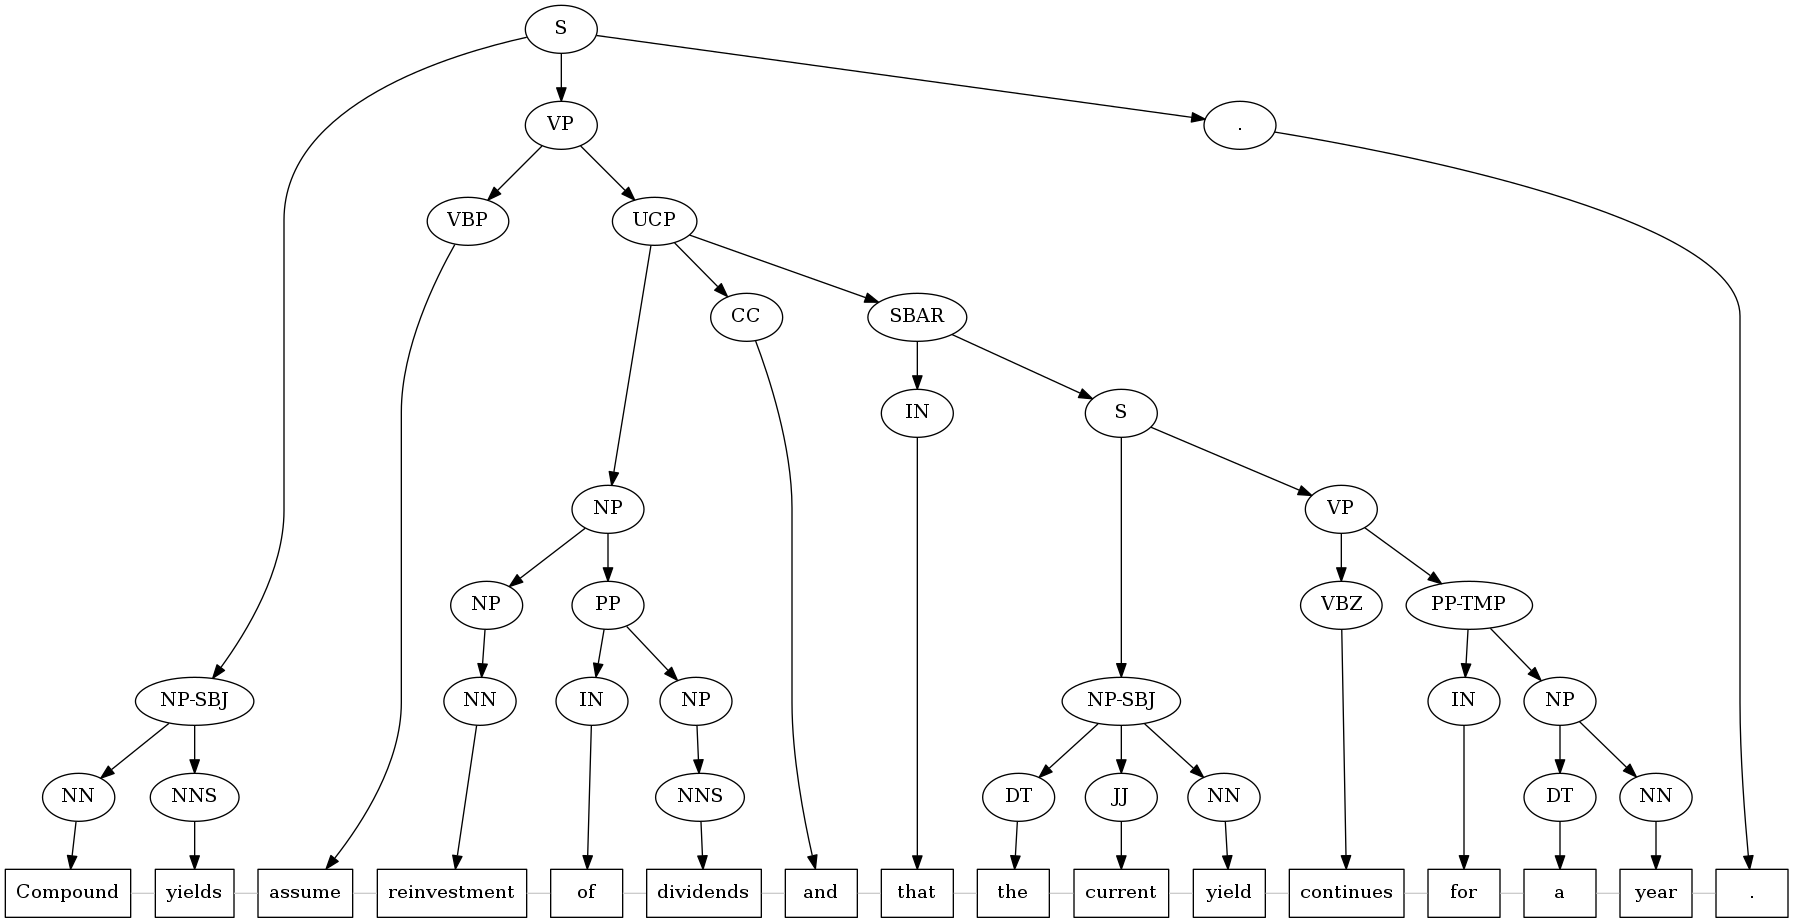

In [46]:
# Monkey-patch NLTK
# This overrides the normal Tree display if running on Cloud or other display-less server.
# if not os.getenv("DISPLAY"):
#     print "Display-less server detected!"
print "Overriding nltk.tree.Tree pretty-printing to use custom GraphViz."
nltk.tree.Tree._repr_png_ = lambda _: None
nltk.tree.Tree._repr_html_ = lambda self: treeviz.render_tree(self, title=treeviz.make_title(self),
                                                             format='png')

corpus.parsed_sents()[35]

## Part (a) Exercises: API warm-up

We'll be using `nltk.tree.Tree` objects in the rest of the assignment, which provide some convenient methods for viewing and traversing parse trees, as well as extracting grammar rules (productions).

The API is documented here: http://www.nltk.org/api/nltk.html#nltk.tree.Tree

In the cells below, do the following to familiarize yourself with the Tree API:

1. Construct the tree `(S (NP foo) (VP bar))` using the Tree API. The constructor can be called as: `Tree(lhs, [rhs_1, rhs_2, ...]` where `lhs` is a string and `rhs_*` are either trees or strings.
2. Display the tree for the first sentence in the corpus. (It should be: "Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 .")
3. For the first sentence, print the label of the root node and the labels of its immediate children.
4. For the first sentence, print all the productions in the sentence. Also print the LHS of the first production, and the RHS of the second production.


In [7]:
## Part (a).1
#### YOUR CODE HERE ####
print Tree('S', [Tree('NP', ['foo']), Tree('VP', ['bar'])])
#### END(YOUR CODE) ####

(S (NP foo) (VP bar))


Tree('S', [Tree('NP-SBJ', [Tree('NP', [Tree('NNP', ['Pierre']), Tree('NNP', ['Vinken'])]), Tree(',', [',']), Tree('ADJP', [Tree('NP', [Tree('CD', ['61']), Tree('NNS', ['years'])]), Tree('JJ', ['old'])]), Tree(',', [','])]), Tree('VP', [Tree('MD', ['will']), Tree('VP', [Tree('VB', ['join']), Tree('NP', [Tree('DT', ['the']), Tree('NN', ['board'])]), Tree('PP-CLR', [Tree('IN', ['as']), Tree('NP', [Tree('DT', ['a']), Tree('JJ', ['nonexecutive']), Tree('NN', ['director'])])]), Tree('NP-TMP', [Tree('NNP', ['Nov.']), Tree('CD', ['29'])])])]), Tree('.', ['.'])])
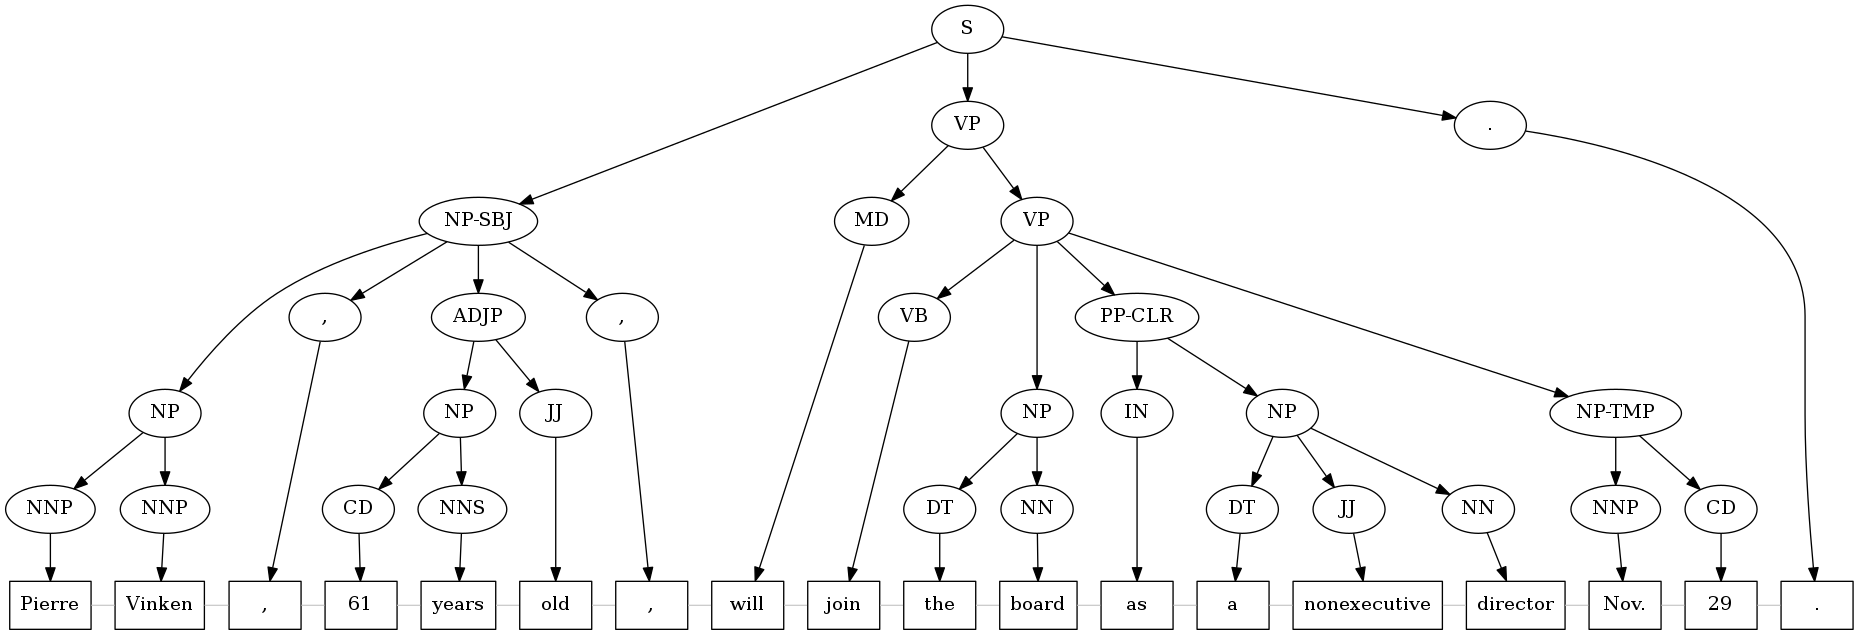

In [8]:
## Part (a).2
#### YOUR CODE HERE ####
nltk.tree.Tree._repr_png_ = lambda _: None
nltk.tree.Tree._repr_html_ = lambda self: treeviz.render_tree(self, title=treeviz.make_title(self),
                                                             format='png')

corpus.parsed_sents()[0]
#### END(YOUR CODE) ####

In [53]:
## Part (a).3
#### YOUR CODE HERE ####
s = corpus.parsed_sents()[0]
print 'root label: %s' %s.label()
for x in range(len(s)):
    print 'label of child %d of root: %s' %(x, s[x].label())
#### END(YOUR CODE) ####

root label: S
label of child 0 of root: NP-SBJ
label of child 1 of root: VP
label of child 2 of root: .


In [55]:
## Part (a).4
#### YOUR CODE HERE ####
s = corpus.parsed_sents()[0]
print 'All productions of sentence:', s.productions()
print 'LHS of the first production:', s[0].productions()[0].lhs()
print 'RHS of the second production:', s[1].productions()[0].rhs()
#### END(YOUR CODE) ####

All productions of sentence: [S -> NP-SBJ VP ., NP-SBJ -> NP , ADJP ,, NP -> NNP NNP, NNP -> 'Pierre', NNP -> 'Vinken', , -> ',', ADJP -> NP JJ, NP -> CD NNS, CD -> '61', NNS -> 'years', JJ -> 'old', , -> ',', VP -> MD VP, MD -> 'will', VP -> VB NP PP-CLR NP-TMP, VB -> 'join', NP -> DT NN, DT -> 'the', NN -> 'board', PP-CLR -> IN NP, IN -> 'as', NP -> DT JJ NN, DT -> 'a', JJ -> 'nonexecutive', NN -> 'director', NP-TMP -> NNP CD, NNP -> 'Nov.', CD -> '29', . -> '.']
LHS of the first production: NP-SBJ
RHS of the second production: (MD, VP)


# (a) Preprocessing

### Removing Cross-References

This first step of preprocessing takes the treebank, strips out the cross references (NPs are wrapped by special nodes that assign index numbers to them so that coreferences can be indicated).  Unfortunately, this also injects a NP-SBJ-# node between nodes you'd expect to produce one another.  Since the # changes throughout the corpus, our counts of the production rules all end up being 1 - and useless.

See NP-SBJ-1 in the tree below.  Note there is also a NP-SBJ leading to a NONE/1 subtree as a crossreference later.

In the code below we skip over nodes whose label start with NP-, connecting any children nodes to the NP-'s parent.  We also snip out any subtrees rooted by NONE.  The tree above is printed again after this next cell to illustrate the effect of this code.

### Chomsky Normal Form

Finally, CKY assumes that trees are constructed from a grammar that is in [Chomsky normal form](https://en.wikipedia.org/wiki/Chomsky_normal_form).

This means that the grammar only consists of three types of rules:
- **Binary nonterminal:** `A -> B C`
- **Unary preterminal:** `A -> a`
- **Epsilon:** `A -> `$\ \ \epsilon$

where `A`, `B`, and `C`, are non-terminals, `a` is a terminal, and $\epsilon$ is the empty sentence.

In order to accomplish this, we add new non-terminals to the language and build longer sequences of non-terminals through them.   
For example, the ternary rule
- `A -> B C D`

becomes two rules:
- `A -> B A|<C-D>`
- `A|<C-D> -> C D`

where `A|<C-D>` is a dummy symbol that we add to signifiy that it's a production of `A` that creates `C D`.

Since the resulting tree is (at most) binary, we sometimes call this process _binarization_.

#### Horizontal Markovization

The dummy-symbol system works well until you get very long grammar rules such as
- `A -> B C D E F G H I J K L`

If we followed the rule above, we'd get intermediate symbols that look like `A|<B-C-D-E-F-G-H-...>`. This would quickly lead to an explosion in the number of symbols in our grammar! Because such long productions are fairly rare, we may have trouble getting good estimates of their probability. (*Recall the sparsity problem from Week 2!*)

One way to counter this is called _horizontal Markovization_. Similar to how in language modeling, we "forgot" all history more than (n-1) words back, we can simply choose to truncate the the history and only store shorter symbols like `A|<B-C>`, `A|<C-D>`, `A|<D-E>`, and so on. This way, we can share parameters across more examples that are similar in structure.

NLTK implements this for us in the `chomsky_normal_form` function; try changing the **`horzMarkov`** parameter below to see how it works.

and week 2's sparsity concerns should be coming to mind.  To keep our counts relatively large, there is a hyperparameter we can pick (analogous to the n of n-gram) called the horizontal markovization parameter.  It does just what you'd expect: it controls how the number of symbols after the pipe in the node name.  This allows evidence to collect across more examples that are similar in structure.

Take a minute to play with the ```horzMarkov``` parameter in the block below to see how this works. 

In [31]:
sentence = corpus.parsed_sents()[35]
# Filter out NP-* nodes.
cleaned_sentence = part2_helpers.copy_strip_np_sbj(sentence)
# Convert sentence to Chomsky normal form.
cnf_sentence = copy.deepcopy(cleaned_sentence)
nltk.treetransforms.chomsky_normal_form(cnf_sentence, horzMarkov=2)
display(HTML(treeviz.render_tree(cleaned_sentence, title="Original", format='svg')))
display(HTML(treeviz.render_tree(cnf_sentence, title="Binarized (CNF)", format='svg')))

### Run Pre-Processing on Corpus

We'll loop through the whole corpus, and make copies of each sentence in CNF form. Use the `cnf_sentences` list for training the grammar in part (b).

**Note:** if you're using the `treebank` corpus sample, this should run in just a few seconds. But if you use the full Penn Treebank, it'll take around 1-2 minutes to process all the trees. If you get an error "`AttributeError: 'tqdm' object has no attribute 'miniters'`", ignore it - the code should still work.

In [3]:
# Preprocess the treebank.
cleaned_sentences = []
cnf_sentences = []
for sentence in ProgressBar(corpus.parsed_sents(), desc="Processing sentences"):
    # Filter out NP-* nodes.
    cleaned_sentence = part2_helpers.copy_strip_np_sbj(sentence)
    cleaned_sentences.append(cleaned_sentence)
    
    # Convert sentence to Chomsky normal form.
    cnf_sentence = copy.deepcopy(cleaned_sentence)
    nltk.treetransforms.chomsky_normal_form(cnf_sentence, horzMarkov=2)
    cnf_sentences.append(cnf_sentence)

Processing sentences: 100%|██████████| 3914/3914 [00:07<00:00, 535.07it/s]


# (b) Production rule probabilities

In this next section, you'll compute about production rule probabilities.

We won't use epsilon rules, so all of our rules will be of the form:
- Binary nonterminal: `A -> B C`
- Unary preterminal: `A -> a`

The left hand side (LHS) of these rules only ever consist of a single nonterminal.  The right hand side (RHS) consists of either two non-terminals or one terminal.

We'll do this in two stages:
- Count LHS, and (LHS,RHS) each in their own dict
- Calculate $ P(RHS | LHS) = \frac{count(LHS, RHS)}{count(LHS)} $

## Part (b) Implementation: Training the grammar

Now that you're comfortable with NLTK Tree objects, let's use them to build our grammar. We've implemented a skeleton in **`pcfg.py`**; your job is to finish the implementation of the `pcfg.PCFG` class. Specifically:

- Implement `update_counts`, which updates the production counts for a single sentence.
- Implement `compute_scores`, which computes log-probabilities.

Read the documentation in `pcfg.py` for the names of the data structures you should populate, and their precise types. Both functions should be straightforward, and only require a couple of lines of code each!

#### Indexing Rules

Your code here need only deal with straightforward maps of productions, but in order to parse efficiently we need to build an inverted index, keyed on the rule's RHS. This way, we can quickly look up rules (and their scores) that would combine two subtrees during the CKY algorithm.

We've implemented this for you in `pcfg.PCFG.build_index()`, but you'll want to look carefully at how that function works - when you implement CKY in part(c), you'll make heavy use of the `grammar.parsing_index` structure.

### Testing `update_counts()`

If everything works, you should see this in the cell below:

```
Top productions:
(, -> ',', 4885)
(PP -> IN NP, 4045)
(DT -> 'the', 4038)
(. -> '.', 3828)
(S|<VP-.> -> VP ., 3018)
(IN -> 'of', 2319)
(NP -> NP PP, 2188)
(TO -> 'to', 2161)
(NP -> DT NN, 2020)
(DT -> 'a', 1874)
```

### Testing `compute_scores()`

If everything went well, you should see:
```
food [(NN, -6.71280430578804)]
a [(IN, -9.19593714166544), (DT, -1.4717815426061982), (LS, -2.5649493574615367), (JJ, -7.978310969867721)]
I [(NNP, -8.45638105201948), (PRP, -2.720363461335567)]
```

In [4]:
reload(pcfg)

grammar = pcfg.PCFG()
for sentence in ProgressBar(cnf_sentences, desc="Counting productions"):
    grammar.update_counts(sentence)
    
print "Top productions:"
for p in grammar.top_productions():  # Top productions, by un-normalized count
    print p
print ""

grammar.compute_scores()  # compute log-probabilities
grammar.build_index()     # prepare for parsing

for w in ['food', 'a', 'I']:
    print w, grammar.parsing_index[(w,)]

Counting productions: 100%|██████████| 3914/3914 [00:02<00:00, 1536.09it/s]


Top productions:
(, -> ',', 4885)
(PP -> IN NP, 4045)
(DT -> 'the', 4038)
(. -> '.', 3828)
(S|<VP-.> -> VP ., 3018)
(IN -> 'of', 2319)
(NP -> NP PP, 2188)
(TO -> 'to', 2161)
(NP -> DT NN, 2020)
(DT -> 'a', 1874)

food [(NN, -6.7128043057880404)]
a [(IN, -9.1959371416654392), (DT, -1.4717815426061982), (LS, -2.5649493574615367), (JJ, -7.9783109698677208)]
I [(NNP, -8.4563810520194806), (PRP, -2.7203634613355669)]


You don't need to do anything with this next cell except to run it.

It's not particularly useful, but if you need to keep track of what each variable contains, this provides a useful reference.

In [5]:
print 'Productions (nltk.grammar.Production):'
for (production, count) in grammar.production_counts.most_common(5):
    print (production, count)

print '\n\nLHS counts:'
for (lhs, count) in grammar.lhs_counts.most_common(5):
    print (lhs, count)
    
print '\n\nLog Probabilities:'
print '\n'.join([str(x) for x in grammar.parsing_index.iteritems()][0:10])

Productions (nltk.grammar.Production):
(, -> ',', 4885)
(PP -> IN NP, 4045)
(DT -> 'the', 4038)
(. -> '.', 3828)
(S|<VP-.> -> VP ., 3018)


LHS counts:
(NP, 23724)
(VP, 14510)
(NN, 13166)
(IN, 9857)
(NNP, 9410)


Log Probabilities:
((u'truce',), [(NN, -8.3867807393597129)])
((VBD, VP|<RB-S>), [(VP, -9.5825933458782337)])
((u'trimmed',), [(VBN, -7.6657534318616989)])
((JJ, S|<NN-PRP>), [(S|<JJ-NN>, -5.3706380281276624)])
((NNP, S|<.-NNP>), [(S|<NNP-.>, -0.69314718055994529)])
((PRP$, NP|<JJ-CD>), [(NP, -9.3810952923986726)])
((u'iota',), [(NN, -9.485393028027822)])
((CC, S|<S-.>), [(S|<CC-S>, -0.31845373111853537)])
((u'resolve',), [(VB, -6.7468037479243748)])
((u'waited',), [(VBD, -8.0205991498969702)])


# (c) Implement CKY

After that bit of preamble, you only have one more task to go!  It's a big one though, so do take your time and get things right. 

**In `cky.py`, implement the `CKY_apply_preterminal_rules` and `CKY_apply_binary_rules` functions.**

We've set up the skeleton of the CKY algorithm for you in the `CKY` function; be sure to read the in-line comments there carefully before you start. The outline is:
1. Construct the chart (`make_chart`, provided)
2. Populate the first row of the chart using preterminal rules (`CKY_apply_preterminal_rules`)
3. Populate the rest of the chart using binary rules (`CKY_apply_binary_rules`)
4. Read off the top cell for the final derivation. (provided)

We'll implement the chart itself as a dict that you can index into first by cell position and then by non-terminal like this:
```
chart[(0, 1)][NN]
```

The value is an [nltk.tree.ProbabilisticTree](http://www.nltk.org/api/nltk.html#nltk.tree.ProbabilisticTree), which is just like an `nltk.tree.Tree` except that it has an additional `logprob()` method that returns the score (log-probability). Similarly, the constructor takes an additional argument: `pt = ProbabilisticTree(lhs, (rhs_1,...), logprob=score)` - you should use this to construct the backtrace trees.

See the in-line comments in `cky.py` for additional hints and advice.

In [23]:
reload(cky)
reload(cky_test)
unittest.TextTestRunner(verbosity=2).run(
    unittest.TestLoader().loadTestsFromName(
        'TestParsing', cky_test))

test_failing_rule_application (cky_test.TestParsing) ... ok
test_rule_application (cky_test.TestParsing) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

ProbabilisticTree(S, [ProbabilisticTree(PRP, ['I']) (p=0.15173612851696769), ProbabilisticTree(VP, [ProbabilisticTree(VBP, ['eat']) (p=0.0068668096876260687), ProbabilisticTree(NP, [ProbabilisticTree(NP, [ProbabilisticTree(JJ, ['red']) (p=0.0039654190017090543), ProbabilisticTree(NP|<JJ-NN>, [ProbabilisticTree(JJ, ['hot']) (p=0.0039654190017090543), ProbabilisticTree(NN, ['food']) (p=0.0095333282960814777)]) (p=3.2078091828121638e-05)]) (p=1.9686276631842462e-09), ProbabilisticTree(PP, [ProbabilisticTree(IN, ['with']) (p=0.10602582040574654), ProbabilisticTree(NP, [ProbabilisticTree(DT, ['a']) (p=0.36053680734251442), ProbabilisticTree(NN, ['knife']) (p=0.0013951219699423914)]) (p=9.1202680157185834e-05)]) (p=8.1694030121337435e-06)]) (p=3.0821169786399291e-15)]) (p=1.0290578432464014e-18)]) (p=2.9329759396127162e-20)
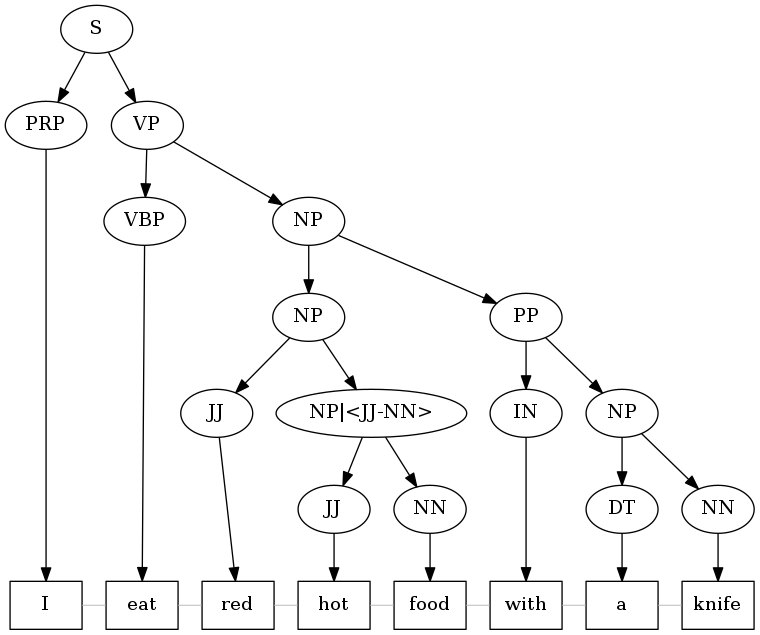

In [41]:
reload(cky)
derivation = cky.CKY('I eat red hot food with a knife'.split(), grammar, 'S')

assert round(derivation.logprob(), 2) == -64.89
derivation

### Experimentation

Try a few more sentences.  Do you notice any patterns with your results?  Any common types of errors?  Are these an artifact of CYK, or of how you did the markovization/counting?

Put any code you write in the next cell and a writeup of the results in the cell after.

(If you have a format that's more natural to your description, feel free to deviate from this format.)

ProbabilisticTree(S, [ProbabilisticTree(DT, ['This']) (p=0.025055435922982799), ProbabilisticTree(VP, [ProbabilisticTree(VBZ, ['is']) (p=0.4497646113248126), ProbabilisticTree(VP|<DT-NN>, [ProbabilisticTree(DT, ['a']) (p=0.36053680734251442), ProbabilisticTree(VP|<NN-NN>, [ProbabilisticTree(NN, ['novel']) (p=0.0036469378597032242), ProbabilisticTree(VP|<NN-JJ>, [ProbabilisticTree(NN, ['sentence']) (p=0.0013951219699423914), ProbabilisticTree(VP|<JJ-NN>, [ProbabilisticTree(JJ, ['to']) (p=0.0024526240952550426), ProbabilisticTree(NN, ['test']) (p=0.016075055141421015)]) (p=2.4884941962858331e-05)]) (p=2.1472900779775786e-08)]) (p=8.6522597711263249e-12)]) (p=6.094587654046323e-13)]) (p=3.1416614674688794e-15)]) (p=1.3299008532096285e-18)
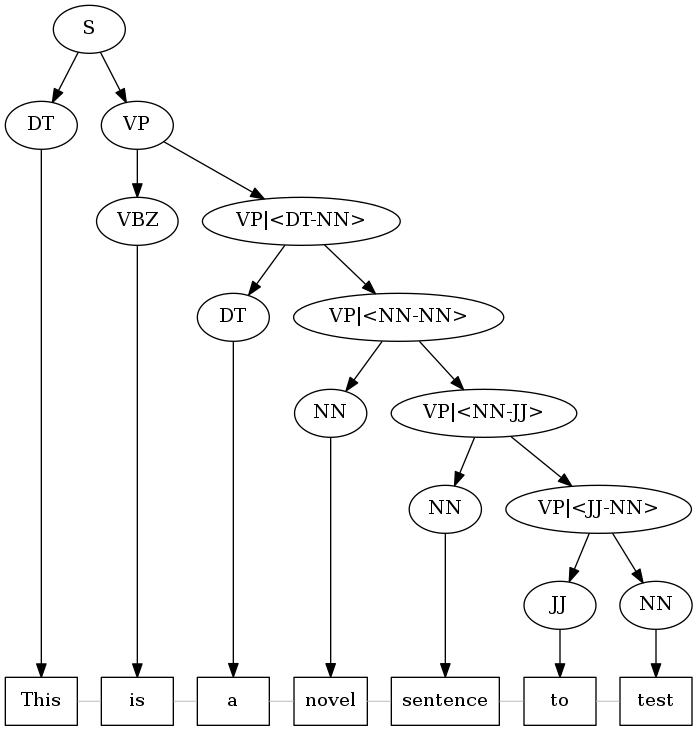

In [45]:
#### YOUR CODE HERE ####
reload(cky)
derivation = cky.CKY('This is a novel sentence to test'.split(), grammar, 'S')

#assert round(derivation.logprob(), 2) == -64.89
derivation
#### END(YOUR CODE) ####

#### Your observation title 1
Your observation detail.  (Copy and paste these two lines and fill them in for each observation.)